In [7]:
import pandas as pd 
import numpy as np
import yfinance as yf
import copy
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [2]:
tickers = ['AAPL', 'AMZN', 'C', 'CVS', 'MMM', 'SBUX', 'SCHW', 'XOM']
start = '2000-06-02'
end = '2016-04-26' 
end2 = dt.datetime.today()

### Import Data

In [3]:
AdjClose = yf.download(tickers, start=start, end=end)['Adj Close']
Volume = yf.download(tickers, start=start, end=end)['Volume']
High = yf.download(tickers, start=start, end=end)['High']
Low = yf.download(tickers, start=start, end=end)['Low']
Close = yf.download(tickers, start=start, end=end)['Close']

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed


In [4]:
AdjClose_Validation = yf.download(tickers, start=end, end=end2)['Adj Close']
Volume_Validation = yf.download(tickers, start=end, end=end2)['Volume']
High_Validation = yf.download(tickers, start=end, end=end2)['High']
Low_Validation = yf.download(tickers, start=end, end=end2)['Low']
Close_Validation = yf.download(tickers, start=end, end=end2)['Close']

[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed
[*********************100%***********************]  8 of 8 completed


### Exponential Smoothing Function

In [12]:
def exponential_smoothing(df, alpha):
    DF = df.copy().reset_index(drop=True) 
    DF.loc[1] = (DF.loc[1]*alpha)+(DF.loc[0]*(1-alpha))
    
    for i in range(2, len(DF)-1):
        DF[i] = (DF[i]*alpha)+(DF[i-1]*(1-alpha))
    
    return DF

E = {}
for n in AdjClose.columns:
    E[f'{n}']= exponential_smoothing(AdjClose[n], 0.2)

### Feature Derivation

### On Balance Volume

In [6]:
def OBV(df_price, df_volume):
    OBV_df = pd.DataFrame(index=range(len(df_volume.index)), columns=['OBV'])
    OBV_df.iloc[0] = 0
    
    for i in range(1, len(df_price)):
        if df_price[i] > df_price[i-1]:
            OBV_df.loc[i] = (OBV_df.loc[i-1] + df_volume[i])
        elif df_price[i] < df_price[i-1]:
            OBV_df.loc[i] = (OBV_df.loc[i-1] - df_volume[i])
        else:
            OBV_df.loc[i] = (OBV_df.loc[i-1] + 0)
    
    OBV_df.index = df_volume.index
    return OBV_df

O = {}
for n in AdjClose.columns:
    O[f'{n}']= OBV(E[n], Volume[n])

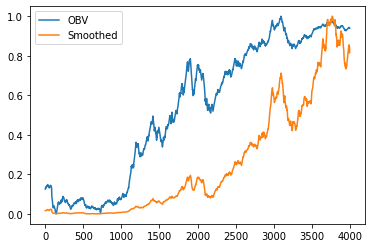

In [7]:
plt.plot(((O['AAPL']-O['AAPL'].min())/(O['AAPL'].max()-O['AAPL'].min())).reset_index(drop=True), label='OBV')
plt.plot((E['AAPL']-E['AAPL'].min())/(E['AAPL'].max()-E['AAPL'].min()), label='Smoothed')
plt.legend()

#### Stochastic Oscillator

In [9]:
def stochastic_oscillator(close, df_low, df_high, K):
    "remember not to use AdjClose"
    low = df_low.rolling(K).min().reset_index(drop=True)
    high = df_high.rolling(K).max().reset_index(drop=True)
    
    stoch_oscillator = pd.DataFrame()
    stoch_oscillator['Oscillator'] = 100*((close - low)/(high - low))
    
    return stoch_oscillator

S = {}
for n in AdjClose.columns:
    S[f'{n}']= stochastic_oscillator(close=E[n], df_low=E[n], df_high=E[n], K=14)

#### Moving Average Convergence Divergence

In [14]:
# New One for Validation Set
def MACD(data):
    MA_Fast = data.ewm(span=12,min_periods=12).mean()
    MA_Slow = data.ewm(span=26,min_periods=26).mean()
    MACD = MA_Fast - MA_Slow
    Signal = MACD.ewm(span=9,min_periods=9).mean()
    
    return pd.DataFrame(index=['MACD', 'Signal'], data=[MACD,Signal]).T

M = {}
for n in AdjClose.columns:
    M[f'{n}'] = MACD(data=E[n])

### Concatenate functions in a single dictionary

In [15]:
dict_data = {}
for n in AdjClose.columns:
    dict_data[f'{n}'] = (pd.concat([E[n], 
                                    O[n].reset_index(drop=True), 
                                    S[n], 
                                    M[n]],
                                   axis=1)).set_index(O[n].index)

### Application of all functions to validation set

In [16]:
# Smoothing
E_validation = {}
for n in AdjClose_Validation.columns:
    E_validation[f'{n}']= exponential_smoothing(AdjClose_Validation[n], 0.2)
    
# On Balance Volume
O_validation = {}
for n in AdjClose_Validation.columns:
    O_validation[f'{n}']= OBV(E_validation[n], Volume_Validation[n])

# Stochastic Oscillator
S_validation = {}
for n in AdjClose_Validation.columns:
    S_validation[f'{n}']= stochastic_oscillator(close=E_validation[n], df_low=E_validation[n], df_high=E_validation[n], K=14)
    
# Moving Average Convergence Divergence
M_validation = {}
for n in AdjClose_Validation.columns:
    M_validation[f'{n}'] = MACD(data=pd.Series(E_validation[n]))
    
# Concatenate all together    
dict_data_validation = {}
for n in AdjClose_Validation.columns:
    dict_data_validation[f'{n}'] = (pd.concat([E_validation[n], 
                                               O_validation[n].reset_index(drop=True), 
                                               S_validation[n], 
                                               M_validation[n]], axis=1)).set_index(O_validation[n].index)

### Function to classify the dependent variable Smoothed AdjClose Price as -1 or 1

In [17]:
def finalise_data(DF, column, n):
    df = copy.deepcopy(DF)
    df[column][column] = np.sign(np.log(df[column][column]/df[column][column].shift(n-1)))
    
    return df[column]

### Random Forest Model

In [18]:
def RFClassifier(DF, column, n, validation=False, validation_DF=None, feature_importance=False):
    data = finalise_data(DF=DF, column=column, n=n)
    data.dropna(axis=0, inplace=True)
    
    X = data[['OBV', 'Oscillator', 'MACD', 'Signal']]
    y = data[column]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    model = RandomForestClassifier(n_estimators=100)
    model.fit(X_train,y_train)
    prediction= model.predict(X_test)
    
    Accuracy = metrics.accuracy_score(y_test, prediction)
    Precision = metrics.average_precision_score(y_test, prediction)
    Recall = metrics.recall_score(y_test, prediction)
    F1_score = metrics.f1_score(y_test, prediction)
    
    if validation ==  True:
        validation_data = finalise_data(DF=validation_DF, column=column, n=n)
        validation_data.dropna(axis=0, inplace=True)
        
        X_validation = validation_data[['OBV', 'Oscillator', 'MACD', 'Signal']]
        y_validation = validation_data[column]
        validation_prediction = model.predict(X_validation)
        
        Accuracy_validation = metrics.accuracy_score(y_validation, validation_prediction)
        Precision_validation = metrics.average_precision_score(y_validation, validation_prediction)
        Recall_validation = metrics.recall_score(y_validation, validation_prediction)
        F1_score_validation = metrics.f1_score(y_validation, validation_prediction)
        
        return n, column,Accuracy_validation, Precision_validation, Recall_validation, F1_score_validation
    
    elif feature_importance == True:
        return pd.Series(model.feature_importances_,(X).columns)
        
    else:
        return n, column, Accuracy, Precision, Recall, F1_score

In [19]:
train_test = []
for i in AdjClose.columns:
    for m in range(2,31):
        train_test.append(RFClassifier(DF=dict_data, column=i, n=m))
result = pd.DataFrame(np.array(train_test), columns=['n', 'Ticker', 'Accuracy', 'Precision', 'Recall', 'F1_score'])
result[['F1_score','Recall','Precision','Accuracy']]=result[['F1_score','Recall','Precision','Accuracy']].astype(float)
result['n']=result['n'].astype(int)

In [20]:
validation_res = []
for i in AdjClose.columns:
    for m in range(2,31):
        validation_res.append(RFClassifier(DF=dict_data, column=i, n=m, validation=True, validation_DF=dict_data_validation))
validation_result = pd.DataFrame(np.array(validation_res), columns=['n', 'Ticker', 'AccuracyV', 'PrecisionV', 'RecallV', 'F1_scoreV'])
validation_result[['F1_scoreV','RecallV','PrecisionV','AccuracyV']]=validation_result[['F1_scoreV','RecallV','PrecisionV','AccuracyV']].astype(float)
validation_result['n']=validation_result['n'].astype(int)

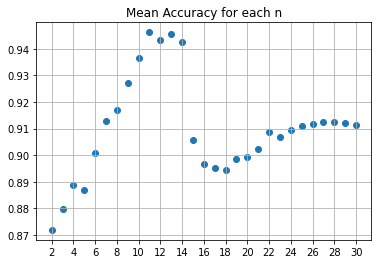

In [21]:
plt.title('Mean Accuracy for each n')
plt.scatter(validation_result.groupby('n').mean().index, validation_result.groupby('n').mean().AccuracyV)
plt.xticks(np.arange(min(validation_result.groupby('n').mean().index), max(validation_result.groupby('n').mean().index)+1, 2.0))
plt.grid()

In [22]:
feature_importances = []
for i in AdjClose.columns:
    for m in range(2,31):
        feature_importances.append(RFClassifier(DF=dict_data, column=i, n=m, validation=False, validation_DF=None, feature_importance=True))
feature_importances_df = pd.DataFrame(np.array(feature_importances), columns=[['OBV', 'Oscillator', 'MACD', 'Signal']], index=result.n)

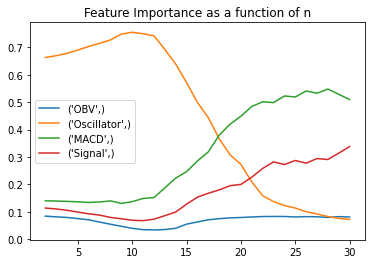

In [23]:
plt.title('Feature Importance as a function of n')
plt.plot(feature_importances_df.groupby(feature_importances_df.index).mean(), label=feature_importances_df.columns)
plt.legend()